In [2]:
from music21 import *
import numpy
import pandas as pd
from music21 import audioSearch as audioSearchBase

C:\Users\brian\AppData\Local\Temp\ipykernel_37868\21783884.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [14]:
def runTranscribe(show, plot, useMic, audioFile,
                  seconds, useScale, saveFile):
    '''
    runs all the methods to record from audio for `seconds` length (default 10.0)
    and transcribe the resulting melody returning a music21.Score object
    
    if `show` is True, show the stream.  
    
    if `plot` is True then a Tk graph of the frequencies will be displayed.

    'audioFile' is a filepath to recorded audio to use instead of the mic if usemic is false
    
    if `useMic` is True then use the microphone.  If False it will load the file of `saveFile`
    or the default temp file to run transcriptions from.
        
    a different scale besides the chromatic scale can be specified by setting `useScale`.
    See :ref:`moduleScale` for a list of allowable scales. (or a custom one can be given).
    Microtonal scales are totally accepted, as are retuned scales where A != 440hz.

    if `saveFile` is False then then the recorded audio is saved to disk.  If
    set to `True` then `environLocal.getRootTempDir() + os.path.sep + 'ex.wav'` is
    used as the filename.  If set to anything else then it will use that as the
    filename. 
    '''

    if useScale is None:
        useScale = scale.ChromaticScale('C4')
    #beginning - recording or not
    if saveFile == True:
        WAVE_FILENAME = 'score.mxl'
    
    # the rest of the score
    if useMic is True:
        print('listening')
        freqFromAQList = audioSearchBase.getFrequenciesFromMicrophone(length=seconds, storeWaveFilename=WAVE_FILENAME)
        print('finished listening')
    else:
        freqFromAQList = audioSearchBase.getFrequenciesFromAudioFile(waveFilename=audioFile)
        
    detectedPitchesFreq = audioSearchBase.detectPitchFrequencies(freqFromAQList, useScale)
    detectedPitchesFreq = audioSearchBase.smoothFrequencies(detectedPitchesFreq)
    (detectedPitchObjects, listplot) = audioSearchBase.pitchFrequenciesToObjects(detectedPitchesFreq, useScale)
    (notesList, durationList) = audioSearchBase.joinConsecutiveIdenticalPitches(detectedPitchObjects)
    myScore, unused_length_part = audioSearchBase.notesAndDurationsToStream(notesList, durationList, removeRestsAtBeginning=True)    

    # This shows the score in MuseScore
    if show == True:
        myScore.show()        
    
    if plot == True:
        try:
            import matplotlib.pyplot # for find
        except ImportError:
            raise audioSearchBase.AudioSearchException("Cannot plot without matplotlib installed.")
        matplotlib.pyplot.plot(listplot)
        matplotlib.pyplot.show()
    print("END")    
        
    return myScore



In [4]:

# NOTE: This does not account for changing tempo (like the example does --> So it is wrong...) but it is not a hard fix.
# Don't use this function for scores created through microphone.

def scoreToDataFrame(score):
    
    if type(score) != stream.PartStaff: #seems to be some differences between PartStaff and Part score types.
        return
    
    dur_beats_list = []
    dur_seconds_list = []
    freq_list = []
    name_list = []
    start_time_list = []

    length = score.metronomeMarkBoundaries()[0][2].numberSounding #quarter notes per minute 
    if length == None:
        length = score.metronomeMarkBoundaries()[0][2].number
    #Note, this up to offset 420.
    qps = 60 / int(length) #quarter notes per second
    
    
    content = score.getElementsByClass('Measure')
    
    for measure in content:
        for n in measure.notesAndRests:
            print(n)
            if (type(n) == chord.Chord):
               
                for my_note in n:
                    #print(note)
                    name = my_note.nameWithOctave
                    freq = my_note.pitch.frequency
                    dur_seconds = my_note.duration.quarterLength * qps
                    dur_beats = my_note.duration.type
                    start_time = (measure.offset + n.offset) * qps #in seconds
                    # note: This is calculated differently than above because the measure.offset gives the offset of the beginning of the measure.
                    
                    dur_beats_list.append(dur_beats)
                    dur_seconds_list.append(dur_seconds)
                    name_list.append(name)
                    freq_list.append(freq)
                    start_time_list.append(start_time)
            elif (type(n) == note.Rest):
                name = n.name
                freq = 0
                dur_seconds = n.duration.quarterLength * qps
                dur_beats = n.duration.type
                start_time = (measure.offset + n.offset) * qps
                
                dur_beats_list.append(dur_beats)
                dur_seconds_list.append(dur_seconds)
                name_list.append(name)
                freq_list.append(freq)
                start_time_list.append(start_time)
            else:
                print(type(n))
    dict_temp = {'Duration in Beats': dur_beats_list, 'Duration in Seconds': dur_seconds_list, 'Name': name_list, 'Frequency': freq_list, 'Start Time in Seconds': start_time_list}
    df = pd.DataFrame(data=dict_temp)
    
    return df

listening
finished listening


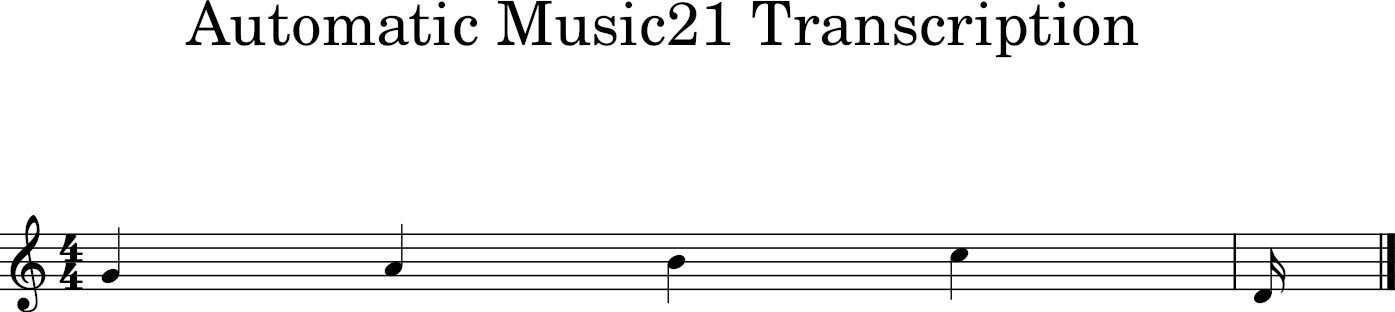

END


In [15]:
# Will listen to microphone audio for 10 seconds and create a Score object from it.
# Output is based on playing eqt-major-sc.wav from my phone
score = runTranscribe(show=True, plot=False, useMic=True, audioFile='',
                  seconds=10.0, useScale=None, saveFile=True)

In [24]:
#chords = score.chordify()

#score
#print(score.length)

In [25]:
score

<music21.stream.Score 0x271b326d950>

In [28]:
dur_beats_list = []
dur_seconds_list = []
freq_list = []
name_list = []
start_time_list = []

length = score.metronomeMarkBoundaries()[0][2].number
qps = 60 / int(length) #quarter notes per second

for my_note in score.flatten():
    #print(el)
    if (type(my_note) == note.Note):
        name = my_note.nameWithOctave
        freq = my_note.pitch.frequency
        dur_seconds = my_note.duration.quarterLength * qps
        dur_beats = my_note.duration.type
        start_time = my_note.offset * qps #in seconds
        
        dur_beats_list.append(dur_beats)
        dur_seconds_list.append(dur_seconds)
        name_list.append(name)
        freq_list.append(freq)
        start_time_list.append(start_time)
    elif type(my_note) == note.Rest:
        name = my_note.name
        freq = 0
        dur_seconds = my_note.duration.quarterLength * qps
        dur_beats = my_note.duration.type
        start_time = (my_note.offset) * qps
        
        dur_beats_list.append(dur_beats)
        dur_seconds_list.append(dur_seconds)
        name_list.append(name)
        freq_list.append(freq)
        start_time_list.append(start_time)



In [29]:
dict_temp = {'Duration in Beats': dur_beats_list, 'Duration in Seconds': dur_seconds_list, 'Name': name_list, 'Frequency': freq_list, 'Start Time in Seconds': start_time_list}
df = pd.DataFrame(data=dict_temp)

In [30]:
df

,Duration in Beats,Duration in Seconds,Name,Frequency,Start Time in Seconds
0,quarter,0.500,G4,391.995436,0.0
1,quarter,0.500,A4,440.000000,0.5
2,quarter,0.500,B4,493.883301,1.0
3,quarter,0.500,C5,523.251131,1.5
4,16th,0.125,D4,293.664768,2.0


In [31]:
score.show(fmt="musicxml")